There are three APIs for building models in Keras: Sequential; Functional; and Model Subclassing. Sequential is limited to a simple stack of layers and is the easiest to use. Functional focuses on graph-like model architectures, and is the most commonly used model-building API in keras. Model subclasssing is a low level option where everything is written from scratch. 

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(64, activation="relu", name="my_first_layer"), layers.Dense(10, activation="softmax")], name="my_model")

# At this point the model isn't built yet, the input shape to the network isn't known!

model.build(input_shape=(None, 30))
model.summary()

model_2 = keras.Sequential()
model_2.add(keras.Input(shape=(3,)))
model_2.add(layers.Dense(64, activation="relu"))
model_2.summary()

# Summary is quite a useful debugging tool!

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                1984      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [18]:
# We start by declaring an input, which holds information about the shape and dtype of the data that the model will process. This is known as a symbolic tensor, it doesn't actually contain any data but it encodes the specifications
# of the actual tensors that the model will see. 
inputs = keras.Input(shape=(3,), name="my_input")

# Next we create a layer and call it on the input! All keras layers can be called on both real and symbolic tensors. When called on symbolic tensors they return another symbolic tensor with the updated tensor shape!
features = layers.Dense(64, activation="relu")(inputs)

outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_13 (Dense)            (None, 64)                256       
                                                                 
 dense_14 (Dense)            (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


Multi-input, multi-output models!

In [19]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4 

# Define the model inputs, title (text), text_body and tags!
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags]) # Combine all the inputs into a single tensor, features, by concatenating them!
features = layers.Dense(64, activation="relu")(features) # Apply an intermediate layer to recombine input features into richer representations

# Define the models outputs! These are a priority value assigned to the IT ticket, and the department is which IT department the ticket is reffered to!
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department]) # Create a Functional model by specifying its inputs and outputs!

Training a multi-input multi-output model

40/40 [==============================] - 0s 1ms/step - loss: 31.3392 - priority_loss: 0.3449 - department_loss: 30.9943 - priority_mean_absolute_error: 0.5085 - department_accuracy: 0.5617


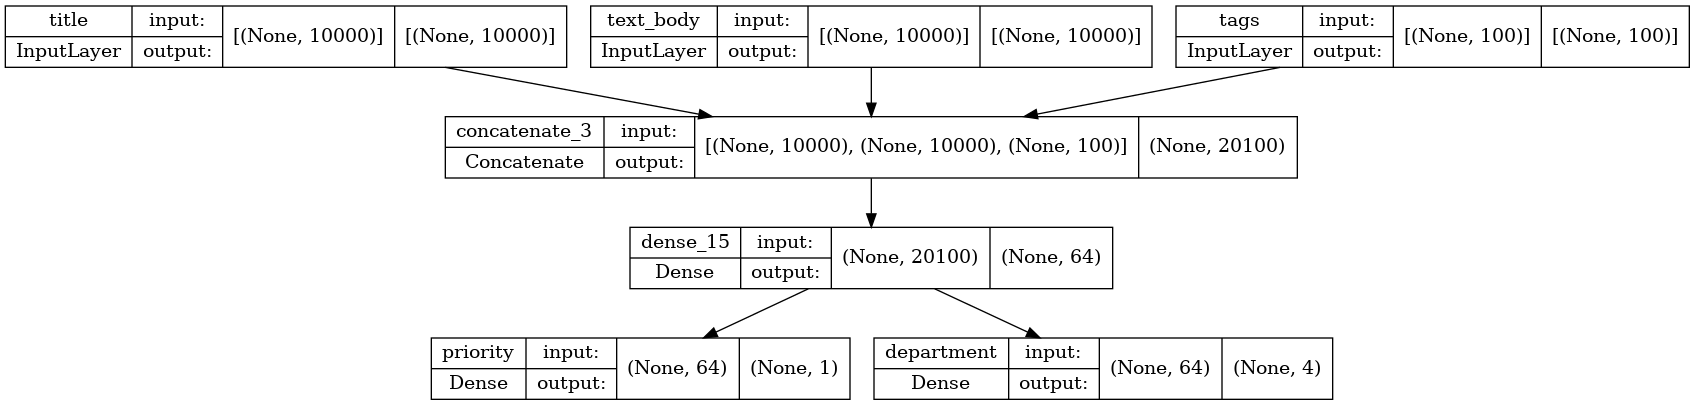

In [20]:
import numpy as np

num_samples = 1280

# Dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# Dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

# Train the model on the data
model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

# If we didn't want to rely on the input order given when the model constructor is ran to specify which data goes where, we can use the names we gave to the Input objects!
model.compile(optimizer="rmsprop", loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"}, metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, {"priority": priority_data, "department": department_data}, epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data}, {"priority": priority_data, "department": department_data})
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

# Plot model is a powerful tool that can be useful for debugging!
keras.utils.plot_model(model, "ticket_classifier.png")
keras.utils.plot_model(model, "ticket_classifier.png", show_shapes=True)

# The "None" in the tensor shape represent the batch size: this model allows batches of any size.

In [21]:
# model.layers
model.layers[3].input
# model.layers[3].output

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

Since we have access to the layers we can do feature extraction! This is creating models that reuse intermediate features from another model. Say for example we wanted to add another output the the previous model (a diffuclty rating given to a ticket), we can do this by adding a classification layer based on the intermediate features produced by this model since we have access to them! 

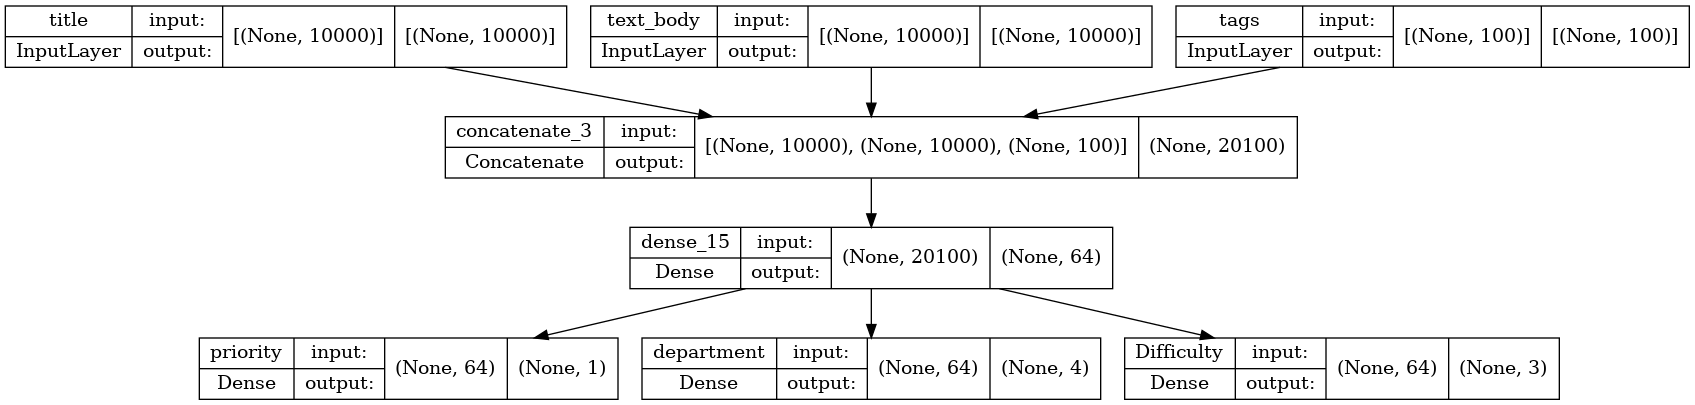

In [22]:
features = model.layers[4].output # This is our intermediate dense layer!
difficulty = layers.Dense(3, activation="softmax", name="Difficulty")(features)

new_model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department, difficulty])

# Lets plot our new model!

keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

The last model-building pattern is Model subclassing. Lets rewrite the customer support ticket management model using a Model subclass!

In [23]:
class CustomerTicketModel(keras.Model): 

    def __init__(self, num_departments):
        super().__init__() # Important to remember to call the super() constructor!
        # Define sublayers in the constructor
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")

    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"] 

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

# Now we have defined our custom class, we can instantiate it!

model = CustomerTicketModel(num_departments=4)

priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})
model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])
# The structure of the input data must match what is expected by the call() method!
# The structure of the target data must match what is returned by the call() method!
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, [priority_data, department_data], epochs=1) 
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data}, [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 2ms/step - loss: 26.5310 - output_1_loss: 0.3279 - output_2_loss: 26.2031 - output_1_mean_absolute_error: 0.4915 - output_2_accuracy: 0.1227


The Model subclassing workflow is the most flexible way to build a model. We can use it to build models that cannot be expressed as directed acyclic graphs of layers, we could have a call() method that uses layers inside a for loop or even calls them recursively! We could really do anything we wanted!

All models in Keras can smoothly interoperate with each other. For instance, we can use a subclassed layer od model in a functional model!

In [24]:
# Creating a functional model that includes a subclassed model!

class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"

        self.dense = layers.Dense(num_units, activation = activation)

    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [25]:
# Creating a subclassed model that includes a functional model!

inputs = keras.Input(shape=(64,))
outputs = layers.Dense(64, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier

    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()


If you can use the Functional API, (i.e. your network can be expressed as a directed acyclic graph of layers), it is recommened to use it! Since we can use subclassed layers with the Functional API it provides the best of both worls in regards to high development flexibility while retaining the advantages of the Functional API! 

In [26]:
# This is the compile(), fit(), evaluate() and predict() workflow we are already familiar with!

from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)

    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

# There are a couple of ways we can customise this workflow: custom metrics; pass callbacks to the fit() method to schedule actions to be taken at specific points during training

Epoch 1/3
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2949 - accuracy: 0.9118 - val_loss: 0.1518 - val_accuracy: 0.9589
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1648 - accuracy: 0.9538 - val_loss: 0.1385 - val_accuracy: 0.9605
Epoch 3/3
313/313 [==============================] - 0s 633us/step - loss: 0.0959 - accuracy: 0.9747


In [27]:
# Lets start with writing our own metrics

import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    # Like for layers, we have access to the add_weight() method! 
    def __init__(self, name="rsme", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

    # Implement the state update logic in update_state(). The y_true argument is the labels for one batch, y_pred is the predictions on this batch!
    def update_state(self, y_true, y_pred,  sample_weight=None):
        # To match our MNIST model, we expect categorical predictions and integer labels!
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    # This method returns the current value of the metric!
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    # We also need a way to reset the metrics state without reinstantiating it!
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

# Lets use our custom metric!

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels, epochs=3, validation_data=(test_images, test_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2933 - accuracy: 0.9122 - rsme: 7.1861 - val_loss: 0.1329 - val_accuracy: 0.9606 - val_rsme: 7.3663
Epoch 2/3
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1635 - accuracy: 0.9533 - rsme: 7.3541 - val_loss: 0.1169 - val_accuracy: 0.9691 - val_rsme: 7.4197
Epoch 3/3
313/313 [==============================] - 0s 502us/step - loss: 0.1072 - accuracy: 0.9726 - rsme: 7.4358


In [ ]:
# The keras callbacks API allows more control during fit()! We pass a callback object to the fit() method of a model which contains methods that the model can call at various points during training!
# There are a few different things that the callback API can do: Model checkpointing; early stopping; dynamically adjusting parameters during optimisation (things like learning rate!); logging/visualising training and validation metrics during training!

# Lets do an example using early stopping and checkpointing!

